# FRANKE FUNCTION TASK 

***Part a)***

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import t
import matplotlib.pyplot as plt

In [2]:
x = np.random.random(15)
y = np.random.random(15)

In [3]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [4]:
data = [[i, j, FrankeFunction(i, j)] for i in x for j in y]

In [5]:
data = np.array(data)

In [6]:
data[:,2] += np.random.random(size=data[:,2].shape)

In [7]:
X, y = np.hsplit(data, [2])

In [8]:
def PolyTransformer(X, degree=5):
    transformedX = list()
    for x,y in X:
        transformedSample = list()
        for p in range(1, degree+1):
            for n in range(p+1):
                transformedSample.append(x**(p-n) * y**n)
        transformedX.append(transformedSample)
    return np.array(transformedX)

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=.8)

In [10]:
train_X = PolyTransformer(train_X)

In [11]:
scaler = StandardScaler()

In [12]:
train_X = scaler.fit_transform(train_X)

In [13]:
beta = train_X.T @ train_X # beta will evolve according to the algorithm

In [14]:
U,S,V = np.linalg.svd(beta, hermitian=True)

# SVD is successful

In [15]:
np.allclose(U @ np.diag(S) @ V, beta)

True

In [16]:
invBeta = V.T @ np.diag(1/S) @ U.T

# Inversion is successful

In [17]:
np.allclose(invBeta, np.linalg.inv(beta))

True

In [18]:
beta = invBeta

In [19]:
beta = beta @ train_X.T

In [20]:
beta = beta @ train_y

In [21]:
def ols(X,y):
    beta = X.T @ X
    U,S,V = np.linalg.svd(beta, hermitian=True)
    inv = V.T @ np.diag(1/S) @ U.T
    beta = inv @ X.T
    return beta

In [22]:
# Calculate confidence interval
def ci(train_X):
    #define var of beta
    var_beta = np.diag(np.linalg.inv(train_X.T @ train_X))
    #define std of beta
    std_beta = np.sqrt(var_beta)
    #define standard error of beta
    se_beta = std_beta / np.sqrt(len(train_X))
    t_value = t.ppf(1-0.025, train_X.shape[0]-train_X.shape[1])
    #lower and upper confidence interval
    CI=np.array([beta-t_value*se_beta, beta+t_value*se_beta])
    lower = beta - t_value * se_beta
    upper = beta + t_value * se_beta
    return (lower, upper)

In [23]:
def mse(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()

In [24]:
def r_2(y_true, y_pred):
    return 1 - ((y_true - y_pred)**2).sum() / ((y_true - y_true.mean())**2).sum()

In [25]:
np.hstack([np.ones(shape=[train_X.shape[0], 1]), train_X])

array([[ 1.        ,  1.56153341, -1.32776358, ..., -0.48876416,
        -0.55206301, -0.64303257],
       [ 1.        ,  0.04956787, -1.13261784, ..., -0.48749602,
        -0.55171352, -0.64297965],
       [ 1.        , -0.02091252,  0.72375797, ..., -0.04415345,
         0.07645876, -0.02984277],
       ...,
       [ 1.        , -0.11130379,  0.59169294, ..., -0.16281394,
        -0.09114451, -0.19340113],
       [ 1.        ,  0.95234298, -0.92206856, ..., -0.47037703,
        -0.54802871, -0.64243173],
       [ 1.        , -1.39159228,  1.35078263, ..., -0.48175178,
        -0.39880682,  1.51075495]])

In [26]:
X_train = np.hstack([np.ones(shape=[train_X.shape[0], 1]), train_X])

In [27]:
beta = ols(X_train, train_y)

In [28]:
mse(X_train @ beta, train_y)

1.0311292432430537

In [29]:
r_2(X_train @ beta, train_y)

-1669.429373673124

In [30]:
X_test = scaler.transform(PolyTransformer(test_X))
X_test = np.hstack([np.ones(shape=[X_test.shape[0], 1]), X_test]) 

In [31]:
mse(test_y, X_test @ beta)

0.9251482866132257

In [32]:
r_2(test_y, X_test @ beta)

-1116.6808881729175

# BIAS VARIANCE TRADEOFF 

***Part b***

In [33]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=.8)

In [34]:
from sklearn.utils import resample

In [35]:
k = 10 # bootstrap

def bootstrap(model, X, y, div = .5, **model_args): # div: proportion of the bootstrap
    test_errors, train_errors = [], []
    if "degree" in model_args: ii = model_args["degree"] 
    for jj in range(k):
        resampled_X , resampled_y = resample(X, y, n_samples=int(train_X.shape[0]/div))
        Train_X, Test_X, Train_y, Test_y = train_test_split(X, y, train_size=.8)
        resampled_X = scaler.fit_transform(Train_X)
        resampled_X = PolyTransformer(resampled_X, degree=ii)
        beta = model(resampled_X, Train_y)

        test_X0 = Test_X
        test_X0 = scaler.transform(test_X0)
        test_X0 = PolyTransformer(test_X0, degree=ii)
    
        pred_y = test_X0 @ beta
        test_errors.append(mse(Test_y, pred_y))
        train_errors.append(mse(Train_y, resampled_X @ beta))
    return np.array(train_errors).mean(), np.array(test_errors).mean() # Return train and test error

In [36]:
complexity = 11

complexity_deg = np.zeros(complexity)
test_error = np.zeros(complexity)
train_error = np.zeros(complexity)

for ii in range(1, complexity):
    complexity_deg[ii] = ii
    train_error[ii], test_error[ii] = bootstrap(ols, train_X, train_y, degree=ii)

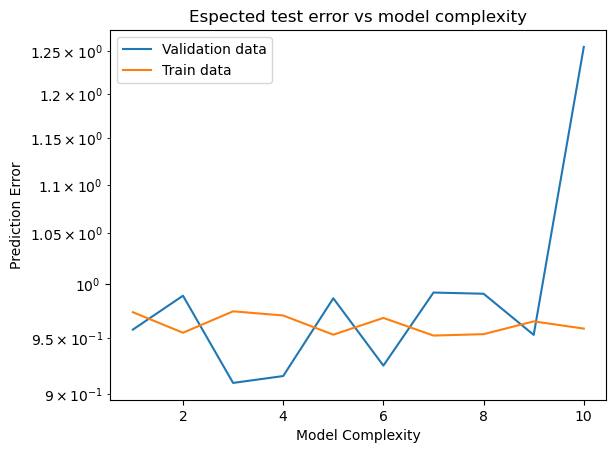

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(complexity_deg[1:], test_error[1:], label='Validation data')
ax.plot(complexity_deg[1:], train_error[1:], label='Train data')
plt.legend()
ax.set_xlabel("Model Complexity")
ax.set_ylabel("Prediction Error")
ax.set_title("Espected test error vs model complexity")
ax.set_yscale('log')
plt.savefig("bias-variance.png", dpi=300, bbox_inches='tight')


# Part c

In [38]:
def cv(model, X, y, fold = 10, **model_args):
    foldSize = int(X.shape[0] / fold)
    Xs = np.vsplit(X, [foldSize * i for i in range(1, fold)])
    ys = np.vsplit(y, [foldSize * i for i in range(1, fold)])
    scores = list()
    if "degree" in model_args: ii = model_args["degree"]
    for i in range(fold):
        validationSet_X = Xs[i:i+1][0]
        trainSet_X = np.concatenate([*Xs[0:i], *Xs[i+1:]], axis=0)
        validationSet_y = y[i:i+1][0]
        trainSet_y = np.concatenate([*ys[0:i], *ys[i+1:]], axis=0)
        scaler = StandardScaler()
        beta = model(PolyTransformer(scaler.fit_transform(trainSet_X), degree=ii), trainSet_y)
        score = mse(PolyTransformer(scaler.transform(validationSet_X), degree=ii) @ beta, validationSet_y)
        scores.append(score)
    return np.array(scores).mean()

In [39]:
test_error = np.zeros(complexity)
for ii in range(1, complexity):
    complexity_deg[ii] = ii
    test_error[ii] = cv(ols, train_X, train_y, degree=ii)

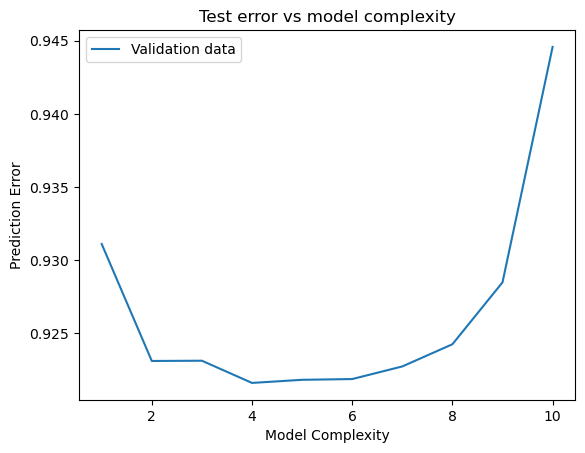

In [40]:
fig, ax = plt.subplots()
ax.plot(complexity_deg[1:], test_error[1:], label='Validation data')
plt.legend()
ax.set_xlabel("Model Complexity")
ax.set_ylabel("Prediction Error")
ax.set_title("Test error vs model complexity")
plt.savefig("cv.png", dpi=300, bbox_inches='tight')

# Part d

In [41]:
def ridge(X, y, l=.1):
    beta = X.T @ X
    beta += np.eye(beta.shape[0]) * l
    U,S,V = np.linalg.svd(beta, hermitian=True)
    beta = inv = V.T @ np.diag(1/S) @ U.T
    beta = beta @ X.T
    return beta

In [42]:
 def ci(train_X, l):
    #define var of beta
    var_beta = np.diag(np.linalg.inv(train_X.T @ train_X + np.eye([train_X.shape[1]] * 2)))
    #define std of beta
    std_beta = np.sqrt(var_beta)
    #define standard error of beta
    se_beta = std_beta / np.sqrt(len(train_X))
    t_value = t.ppf(1-0.025, train_X.shape[0]-train_X.shape[1])
    #lower and upper confidence interval
    CI=np.array([beta-t_value*se_beta, beta+t_value*se_beta])
    lower = beta - t_value * se_beta
    upper = beta + t_value * se_beta
    return (lower, upper)

In [43]:
k = 10 # bootstrap

def bootstrap(model, X, y, div = .5, **model_args): # div: proportion of the bootstrap
    test_errors, train_errors = [], []
    for jj in range(k):
        resampled_X , resampled_y = resample(X, y, n_samples=int(train_X.shape[0]/div))
        Train_X, Test_X, Train_y, Test_y = train_test_split(X, y, train_size=.8)
        resampled_X = scaler.fit_transform(Train_X)
        resampled_X = PolyTransformer(resampled_X)
        beta = model(resampled_X, Train_y, **model_args)

        test_X0 = Test_X
        test_X0 = scaler.transform(test_X0)
        test_X0 = PolyTransformer(test_X0)
    
        pred_y = test_X0 @ beta
        test_errors.append(mse(Test_y, pred_y))
        train_errors.append(mse(Train_y, resampled_X @ beta))
    return np.array(train_errors).mean(), np.array(test_errors).mean() # Return train and test error

In [44]:
lambdas = []
test_error = []
train_error = []

for ii in np.logspace(-3, 2.5, 6):
    lambdas.append(ii)
    train, test = bootstrap(ridge, train_X, train_y, l=ii)
    train_error.append(train)
    test_error.append(test)

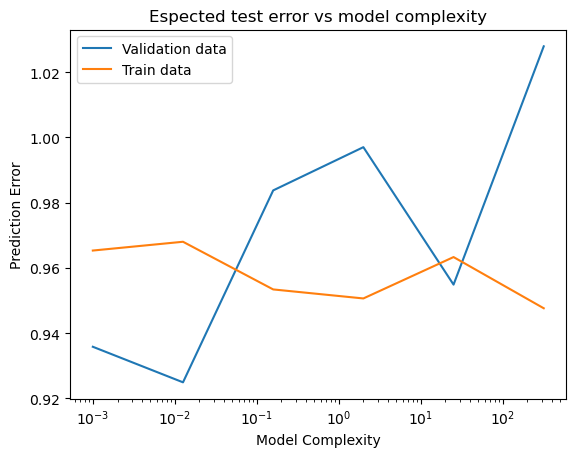

In [45]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(lambdas, test_error, label='Validation data')
ax.plot(lambdas, train_error, label='Train data')
plt.legend()
ax.set_xlabel("Model Complexity")
ax.set_ylabel("Prediction Error")
ax.set_title("Espected test error vs model complexity")
ax.set_xscale("log")
plt.savefig("ridgeBias.png", dpi=300, bbox_inches='tight')

In [46]:
def cv(model, X, y, fold = 10, **model_args):
    foldSize = int(X.shape[0] / fold)
    Xs = np.vsplit(X, [foldSize * i for i in range(1, fold)])
    ys = np.vsplit(y, [foldSize * i for i in range(1, fold)])
    scores = list()
    for i in range(fold):
        validationSet_X = Xs[i:i+1][0]
        trainSet_X = np.concatenate([*Xs[0:i], *Xs[i+1:]], axis=0)
        validationSet_y = y[i:i+1][0]
        trainSet_y = np.concatenate([*ys[0:i], *ys[i+1:]], axis=0)
        scaler = StandardScaler()
        beta = model(PolyTransformer(scaler.fit_transform(trainSet_X)), trainSet_y, **model_args)
        score = mse(PolyTransformer(scaler.transform(validationSet_X)) @ beta, validationSet_y)
        scores.append(score)
    return np.array(scores).mean()

In [47]:
def cv(model, X, y, fold = 10, **model_args):
    foldSize = int(X.shape[0] / fold)
    Xs = np.vsplit(X, [foldSize * i for i in range(1, fold)])
    ys = np.vsplit(y, [foldSize * i for i in range(1, fold)])
    scores = list()
    for i in range(fold):
        validationSet_X = Xs[i:i+1][0]
        trainSet_X = np.concatenate([*Xs[0:i], *Xs[i+1:]], axis=0)
        validationSet_y = y[i:i+1][0]
        trainSet_y = np.concatenate([*ys[0:i], *ys[i+1:]], axis=0)
        scaler = StandardScaler()
        beta = model(PolyTransformer(scaler.fit_transform(trainSet_X)), trainSet_y, **model_args)
        score = mse(PolyTransformer(scaler.transform(validationSet_X)) @ beta, validationSet_y)
        scores.append(score)
    return np.array(scores).mean()

In [48]:
lambdas = []
test_error = []
train_error = []

for ii in np.logspace(-3, 2, 6):
    lambdas.append(ii)
    test = cv(ridge, train_X, train_y, l=ii)
    test_error.append(test)

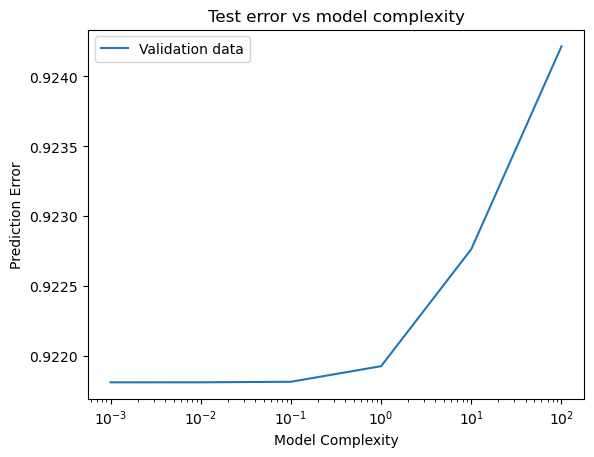

In [49]:
fig, ax = plt.subplots()
ax.plot(lambdas, test_error, label='Validation data')
plt.legend()
ax.set_xlabel("Model Complexity")
ax.set_ylabel("Prediction Error")
ax.set_title("Test error vs model complexity")
ax.set_xscale("log")
plt.savefig("cvRidge.png", dpi=300, bbox_inches='tight')

# part g

## GD

In [50]:
train_X = PolyTransformer(train_X)

In [51]:
scaler = StandardScaler()

In [52]:
train_X = scaler.fit_transform(train_X)

In [53]:
def ridgeOPT(X, y, GD, l=.1 , **opt_args):
    def gradient(X_, y_, beta_):
        return  (- 2 * X_.T @ (y_.reshape(-1, 1) - X_ @ beta_) + 2 * l * beta_) / X_.shape[0]
    beta = GD(gradient, X, y, **opt_args)
    return beta

In [54]:
def GD(gradient, X, y, tol=1e-4):
    learning_rate, descent, beta = 0.01, np.random.random([X.shape[1], 1]), np.random.random([X.shape[1], 1])
    while np.linalg.norm(descent) > tol:
        descent = gradient(X, y, beta)
        beta = beta - learning_rate * descent
    return beta

In [55]:
X_train = np.hstack([np.ones(shape=[train_X.shape[0], 1]), train_X])

In [56]:
beta = ridgeOPT(X_train, train_y, GD)

In [57]:
mse(X_train @ beta, train_y)

0.07563873606000054

In [58]:
r_2(X_train @ beta, train_y)

-0.014093884873245699

## GD with momentum

In [59]:
def GD_m(gradient, X, y, momentum, tol=1e-4):
    learning_rate, descent, beta = 0.01, np.random.random([X.shape[1], 1]), np.random.random([X.shape[1], 1])
    while np.linalg.norm(descent) > tol:
        descent = gradient(X, y, beta) + descent * momentum
        beta = beta - learning_rate * descent
    return beta

In [60]:
beta = ridgeOPT(X_train, train_y, GD_m, momentum=.1)

In [61]:
mse(X_train @ beta, train_y)

0.07564164822696733

In [62]:
r_2(X_train @ beta, train_y)

-0.0141161457015484

## SGD with mini batch

In [63]:
def GD_mb(gradient,  X, y, momentum, batch_size, learning_rate=.01, epoch=10000, tol=1e-4):
    iteration, descent, beta = 0, np.random.random([X.shape[1], 1]), np.random.random([X.shape[1], 1])
    batch_size = int(batch_size)
    if tol <= 0: raise ValueError("'tolerance' must be greater than zero")
    if not 0 < batch_size <= X.shape[0]: 
        raise ValueError("'batch_size' must be greater than zero and less than or equal to the number of observations")
    while epoch > iteration:
        for i in range(0, X.shape[0] - batch_size, batch_size):
            batch_X, batch_y = X[i:i + batch_size], y[i:i + batch_size]
            grad = gradient(batch_X, batch_y, beta)
            descent = grad + descent * momentum
            beta = beta - learning_rate * descent
            if np.linalg.norm(grad) < tol: return beta
            iteration +=1
    else: 
        print(np.linalg.norm(grad))
        raise RuntimeError("Failed to converge to a minimum")

In [64]:
beta = ridgeOPT(X_train, train_y, GD_mb, momentum=.5, batch_size=90, learning_rate=0.01, tol=1e-2)

In [65]:
mse(X_train @ beta, train_y)

0.08152235436383273

In [66]:
r_2(X_train @ beta, train_y)

-0.22278435832387844

## SGD with adagrad

In [67]:
def GD_ag(gradient, X, y, batch_size, learning_rate=.01, epoch=1000, tol=1e-4, epsilon=1e-4):
    iteration, descent, beta = 0, np.random.random([X.shape[1], 1]), np.random.random([X.shape[1], 1])
    batch_size = int(batch_size)
    if tol <= 0: raise ValueError("'tolerance' must be greater than zero")
    if not 0 < batch_size <= X.shape[0]: 
        raise ValueError("'batch_size' must be greater than zero and less than or equal to the number of observations")
    while epoch > iteration:
        for i in range(0, X.shape[0] - batch_size, batch_size):
            batch_X, batch_y = X[i:i + batch_size], y[i:i + batch_size]
            grad = gradient(batch_X, batch_y, beta)
            descent = descent + grad**2
            beta = beta - learning_rate / np.sqrt(descent + epsilon) * grad
            if np.linalg.norm(grad) < tol: return beta
            iteration +=1
    else: 
        raise RuntimeError("Failed to converge to a minimum")

In [68]:
beta = ridgeOPT(X_train, train_y, GD_ag, batch_size=90, learning_rate=1, tol=1e-2)

In [69]:
mse(X_train @ beta, train_y)

0.08218096630096139

In [70]:
r_2(X_train @ beta, train_y)

-0.18419482832542067

## SGD with adam

In [71]:
def GD_ad(gradient, X, y, batch_size, learning_rate=.01, epoch=1000, tol=1e-4, epsilon=1e-4, beta1=0.9, beta2=0.999):
    iteration, beta = 0, np.random.random([X.shape[1], 1])
    batch_size = int(batch_size)
    if tol <= 0: raise ValueError("'tolerance' must be greater than zero")
    if not 0 < batch_size <= X.shape[0]: 
        raise ValueError("'batch_size' must be greater than zero and less than or equal to the number of observations")
    s_t, v_t, t = 0, 0, 0
    while epoch > iteration:
        for i in range(0, X.shape[0] - batch_size, batch_size):
            batch_X, batch_y = X[i:i + batch_size], y[i:i + batch_size]
            grad = gradient(batch_X, batch_y, beta)
            t = t + 1
            s_t = beta2 * s_t + (1 - beta2) * grad**2
            v_t = beta1 * v_t + (1 - beta1) * grad
            s_cap_t = s_t / (1 - beta2**t)
            v_cap_t = v_t / (1 - beta1**t)
            descent = (learning_rate * v_cap_t) / (np.sqrt(s_cap_t) + epsilon)
            beta = beta - descent
            if np.linalg.norm(grad) < tol: return beta
            iteration +=1
    else: 
        raise RuntimeError("Failed to converge to a minimum")

In [72]:
beta = ridgeOPT(X_train, train_y, GD_ad, batch_size=90, learning_rate=1, tol=1e-2)

In [73]:
mse(X_train @ beta, train_y)

0.0802985313832389

In [74]:
r_2(X_train @ beta, train_y)

-0.1844551169934554